In [8]:
# ----------------------------------------------------------------------------
#
# TITLE - gaiadr2-apogee_dr16_dataset.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Prepare the Gaia DR2 - APOGEE DR16 (AstroNN) dataset.
'''

__author__ = "James Lane"

In [9]:
### Imports

## Basic
import numpy as np
import sys, os, pdb

## Matplotlib
from matplotlib import pyplot as plt

## Astropy
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import table
from astropy import units as apu
from astropy.coordinates import CartesianDifferential

In [10]:
# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.debugger import set_trace

# Meta

## Future work

## Information

# Load
Load AstroNN catalogs and APOGEE catalogs

In [22]:
### Load catalogs

# Names
astronn_catalog_fname = '../../data/astronn/dr16_astronn.npy'

# Load and extract data
astronn_data = np.load(astronn_catalog_fname)

In [23]:
print(str(astronn_data.shape[0])+' stars total')

464132 stars total


In [64]:
print('Catalog names:')
for name in astronn_data.dtype.names:
    print(name)
####

Catalog names:
APSTAR_ID
TARGET_ID
ASPCAP_ID
FILE
APOGEE_ID
TELESCOPE
LOCATION_ID
FIELD
J
J_ERR
H
H_ERR
K
K_ERR
RA
DEC
GLON
GLAT
APOGEE_TARGET1
APOGEE_TARGET2
APOGEE_TARGET3
APOGEE2_TARGET1
APOGEE2_TARGET2
APOGEE2_TARGET3
TARGFLAGS
SURVEY
PROGRAMNAME
NINST
NVISITS
COMBTYPE
COMMISS
SNR
STARFLAG
STARFLAGS
ANDFLAG
ANDFLAGS
VHELIO_AVG
VSCATTER
VERR
VERR_MED
OBSVHELIO_AVG
OBSVSCATTER
OBSVERR
OBSVERR_MED
SYNTHVHELIO_AVG
SYNTHVSCATTER
SYNTHVERR
SYNTHVERR_MED
RV_TEFF
RV_LOGG
RV_FEH
RV_ALPHA
RV_CARB
RV_CCFWHM
RV_AUTOFWHM
SYNTHSCATTER
STABLERV_CHI2
STABLERV_RCHI2
CHI2_THRESHOLD
STABLERV_CHI2_PROB
MEANFIB
SIGFIB
SNREV
APSTAR_VERSION
ASPCAP_VERSION
RESULTS_VERSION
EXTRATARG
MIN_H
MAX_H
MIN_JK
MAX_JK
PARAM
FPARAM
PARAM_COV
FPARAM_COV
TEFF
TEFF_ERR
LOGG
LOGG_ERR
VMICRO
VMACRO
VSINI
M_H
M_H_ERR
ALPHA_M
ALPHA_M_ERR
ASPCAP_CHI2
ASPCAP_CLASS
ASPCAPFLAG
ASPCAPFLAGS
PARAMFLAG
FELEM
FELEM_ERR
X_H
X_H_ERR
X_M
X_M_ERR
C_FE
CI_FE
N_FE
O_FE
NA_FE
MG_FE
AL_FE
SI_FE
P_FE
S_FE
K_FE
CA_FE
TI_FE
TIII_FE
V_FE
CR_FE


In [33]:
### Read catalog values

# ID, RA, Dec, logg, abundances, errors
apid = astronn_data['APOGEE_ID']
locid = astronn_data['LOCATION_ID']
ra = astronn_data['RA']
dec = astronn_data['DEC']

# Distance, distance error, pmRA, pmDec
dist = astronn_data['dist'] / 1000 # In kpc
sdist = astronn_data['dist_error'] / 1000 # In kpc
fsdist = sdist / dist
pmra = astronn_data['PMRA']
pmdec = astronn_data['PMDEC']

# Stellar parameters
teff = astronn_data['TEFF']
steff = astronn_data['TEFF_ERR']
logg = astronn_data['LOGG']
slogg = astronn_data['LOGG_ERR']

# Radial velocity
vhelio = astronn_data['VHELIO_AVG']
svhelio = astronn_data['VERR']

# Kinematics
gc_R = astronn_data['R']
gc_phi = astronn_data['phi']
gc_z = astronn_data['Z']
gc_vR = astronn_data['vR']
gc_vT = astronn_data['vT']
gc_vz = astronn_data['vz']

# Make into a mega-array for easy cutting. Separate by floats and string
all_data_str = np.array([apid, locid]).T
all_data_flt = np.array([ra, dec, dist, sdist, teff, steff, logg, slogg,
    pmra, pmdec, vhelio, svhelio, gc_R, gc_phi, gc_z, gc_vR, gc_vT, gc_vz ]).T

# Perform cuts
Cut the data based on:
- $\sigma_{\log g} < 0.2$
- $\sigma_{d}/d < 0.2$
- $\log g < 3$
- $\mu_{\alpha}$ and $\mu_{\delta}$ not $-9999$ or NaN

In [34]:
### Perform cuts

# Find stars with logg error > 0.2 dex, 
# and fractional distance error > 0.2
good_stars = np.where(  ( slogg < 0.2 ) &
                        ( fsdist < 0.2 ) &
                        ( logg < 3 ) &
                        ( pmra > -9998 ) &
                        ( pmdec > -9998 ) &
                        ( ~np.isnan(pmra) ) &
                        ( ~np.isnan(pmdec) ) &
                        ( pmra != 0. ) &
                        ( pmdec != 0. ) &
                        ( ~np.isnan(gc_vT) ) &
                        ( ~np.isnan(gc_vR) ) &
                        ( ~np.isnan(gc_z) )
                     )[0]

print('Number of stars remaining is: '+str(len(good_stars)))
print('This is about '+str(int(100*len(good_stars)/len(apid)))+'%')

# Cut the large arrays
all_data_flt_good = all_data_flt[good_stars]
all_data_str_good = all_data_str[good_stars]

# Unpack the data
apid, locid = all_data_str_good.T
ra, dec, dist, sdist, teff, steff, logg, slogg, pmra, pmdec, vhelio, svhelio, gc_R, gc_phi, gc_z, gc_vR, gc_vT, gc_vz  = all_data_flt_good.T

Number of stars remaining is: 129237
This is about 27%


In [58]:
### First define the LSR frame:

x_sun = 8.0 # Gravity
z_sun = 0.0208 # Bennett & Bovy 2018
SgrA_pmra = 6.379 # Reid (2004)
u = 11.1  # }
v = 12.24 # } Schoenrich
w = 7.25  # }
v += 220 # Bovy # (SgrA_pmra * x_sun * 4.74) # Gravity x Reid (2004) SgrA* PM

In [59]:
### Make SkyCoord

# Initiate with LSR kinematics from above.
coords = SkyCoord(ra = ra*apu.degree,
                  dec = dec*apu.degree,
                  distance = dist*apu.kpc,
                  pm_ra_cosdec = pmra*apu.mas/apu.yr,
                  pm_dec = pmdec*apu.mas/apu.yr,
                  radial_velocity = vhelio*apu.km/apu.s,
                  galcen_distance = x_sun*apu.kpc,
                  z_sun = z_sun*apu.kpc,
                  galcen_v_sun = CartesianDifferential([u, v, w]*apu.km/apu.s))

In [60]:
### Transform into new frames

coords_gal = coords.transform_to('galactic')
coords_gc = coords.transform_to('galactocentric')

# Get galactic proper motions in mas/yr
pmll = coords_gal.pm_l_cosb.value
pmbb = coords_gal.pm_b.value

# Get galactocentric positions in kpc
jlgc_x = coords_gc.x.value * -1 # Flip for LH
jlgc_y = coords_gc.y.value
jlgc_z = coords_gc.z.value
jlgc_R = np.sqrt( np.square( jlgc_x ) + np.square( jlgc_y ) )
jlgc_phi = np.arctan( jlgc_y, jlgc_x )

# Get galactocentric velocities in km/s
jlgc_vx = coords_gc.v_x.value
jlgc_vy = coords_gc.v_y.value
jlgc_vz = coords_gc.v_z.value

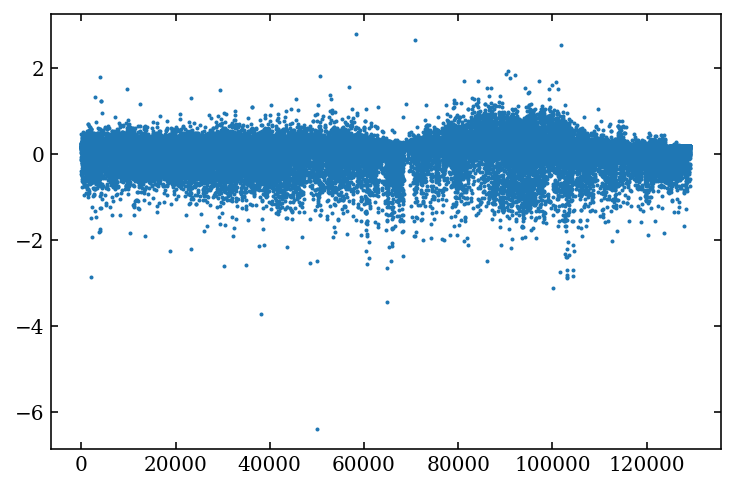

In [61]:
plt.scatter( np.arange(len(jlgc_R)), jlgc_R-gc_R, s=1 )
fig = plt.gcf()
fig.set_facecolor('White')
plt.show()

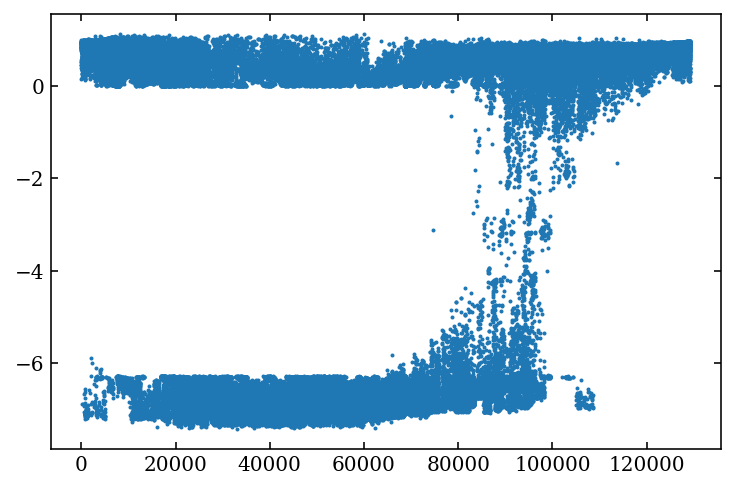

In [62]:
plt.scatter( np.arange(len(jlgc_phi)), jlgc_phi-gc_phi, s=1 )
fig = plt.gcf()
fig.set_facecolor('White')
plt.show()

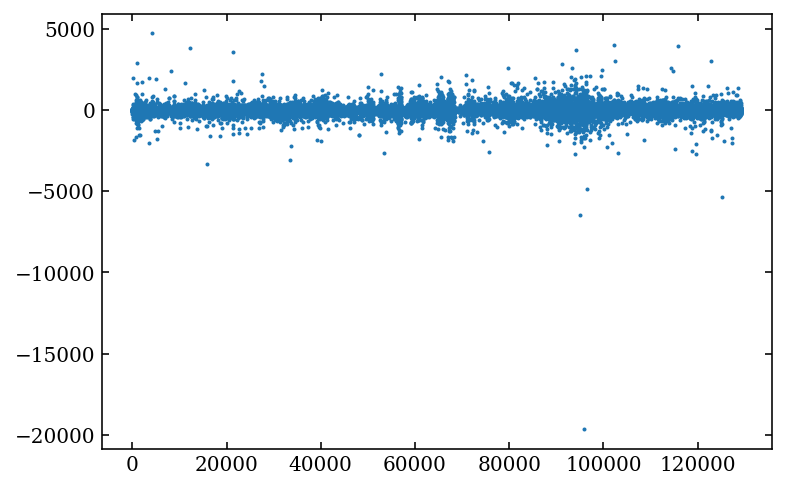

In [63]:
plt.scatter( np.arange(len(jlgc_vz)), jlgc_vz-gc_vz, s=1 )
fig = plt.gcf()
fig.set_facecolor('White')
plt.show()

# Simple validation of $\phi$: Check agreement with galactic longitude
Galactocentric longitudes from 0 to 180 should have positive $\phi$ from 0 to $\pi$. From 180 to 360 should have from $\pi$ to $2\pi$.

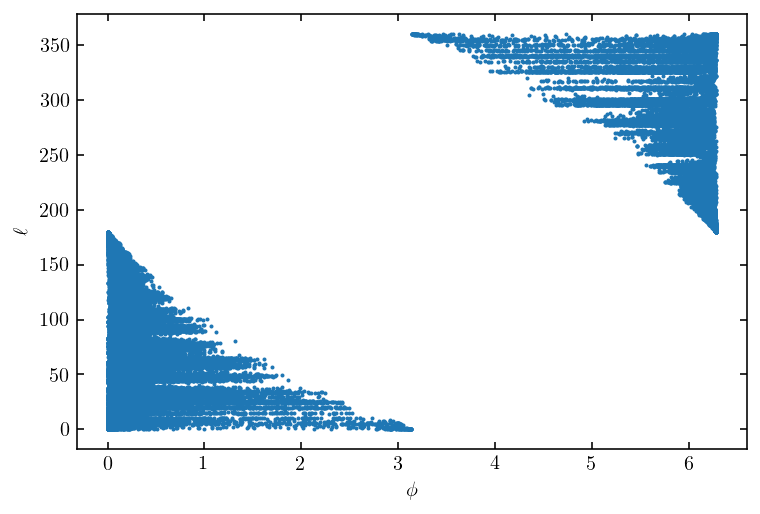

In [10]:
plt.scatter( gc_phi, astronn_data['GLON'][good_stars], s=1 )
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\ell$')
fig = plt.gcf()
fig.set_facecolor('White')
plt.show()

# Save
Save the new dataset

In [12]:
### Save the new dataset

from astropy import table

# Make names
out_names = ('APOGEE_ID',
             'LOCATION_ID',
             'RA',
             'DEC',
             'DIST',
             'DIST_ERROR',
             'VHELIO',
             'VHELIO_ERROR',
             'PM_RA',
             'PM_DEC',
             'R',
             'PHI',
             'Z',
             'VR',
             'VT',
             'VZ',
             'TEFF',
             'TEFF_ERROR',
             'LOGG',
             'LOGG_ERROR')

# Data types
out_dtypes = ('U20', # ID
              'U20', # ID
              'float', # RA
              'float', # DEC
              'float', # DIST
              'float', # DIST_ERR
              'float', # VHELIO
              'float', # VHELIO_ERR
              'float', # PM_RA
              'float', # PM_DEC
              'float', # R
              'float', # PHI
              'float', # Z
              'float', # VR
              'float', # VPHI
              'float', # VZ
              'float', # TEFF
              'float', # TEFF_ERROR
              'float', # LOGG
              'float', # LOGG_ERR
             )

out_data = [apid,
            locid, 
            ra,
            dec,
            dist,
            sdist,
            vhelio,
            svhelio,
            pmra,
            pmdec,
            gc_R,
            gc_phi,
            gc_z,
            gc_vR,
            gc_vT,
            gc_vz,
            teff,
            steff,
            logg,
            slogg,
            ]

# print(len(out_names))
# print(out_names)

# print(len(out_dtypes))
# print(out_dtypes)

print('Outputing this data...')
for i in range(len(out_data)):
    print('-------')
    print(str(i))
    print(out_names[i])
    print(out_data[i])
    print('length: '+str(len(out_data[i])))

out_tab = table.Table(out_data, names=out_names, dtype=out_dtypes)
out_tab.write('../../data/generated/gaiadr2-apogee_dr16_dataset.FIT', overwrite=True)
print('-------')
print('Done')

# No output
pass;

Outputing this data...
-------
0
APOGEE_ID
[b'2M00001199+6114138' b'2M00001296+5851378' b'2M00001328+5725563' ...
 b'2M23595669+6131251' b'2M23595676+7918072' b'2M23595886+5726058']
length: 129237
-------
1
LOCATION_ID
[b'5045' b'4424' b'4264' ... b'5045' b'5047' b'4424']
length: 129237
-------
2
RA
[4.99870000e-02 5.40090000e-02 5.53500000e-02 ... 3.59986225e+02
 3.59986523e+02 3.59995265e+02]
length: 129237
-------
3
DEC
[61.237167 58.8605   57.432327 ... 61.523659 79.302002 57.434956]
length: 129237
-------
4
DIST
[1.79125647 2.59189819 2.7590791  ... 2.97989136 2.38239893 2.51111865]
length: 129237
-------
5
DIST_ERROR
[0.2234639  0.26921869 0.38545931 ... 0.43390669 0.27908593 0.23684135]
length: 129237
-------
6
VHELIO
[-47.25519943   2.57806993 -64.53089905 ... -24.96010017 -38.73849869
 -60.92599869]
length: 129237
-------
7
VHELIO_ERROR
[0.00434606 0.0140458  0.00644101 ... 0.0171545  0.00423116 0.0100566 ]
length: 129237
-------
8
PM_RA
[ 7.69999981  8.         -4.         ..

# End